<a href="https://colab.research.google.com/github/NikitaSavvin2000/CNN-LSTM/blob/main/draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm


df_Pl = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRKJzXJlQSNew0dxrQ8mFQMhBv_4owvfsF2If1b-rmxMZkR5gabHC4OiaSwt8Ul1Omc8taR27UohSeg/pub?gid=429486365&single=true&output=csv')
nan_indices = df_Pl.index[df_Pl['P_l'].isna()]
avg_pl = df_Pl['P_l'].mean()

df_Pl['P_l'].fillna(avg_pl, inplace=True)


df_Pl['time'] = pd.to_datetime(df_Pl['time'])

scaler = MinMaxScaler(feature_range=(0, 1))
df_Pl['Scaled_P_l'] = scaler.fit_transform(df_Pl['P_l'].values.reshape(-1, 1))

look_back = 10
X, y = [], []

for i in tqdm(range(len(df_Pl) - look_back)):
    X.append(df_Pl[['Scaled_P_l', 'time']][i:(i + look_back)].values)
    y.append(df_Pl['Scaled_P_l'][i + look_back])

X, y = np.array(X), np.array(y)




100%|██████████| 762881/762881 [44:52<00:00, 283.29it/s]


In [25]:
from tensorflow.keras.layers import Input, concatenate, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
import numpy as np


time_scaler = MinMaxScaler()

train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size, :], X[train_size:len(X), :]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

# Создание входов
input_cnn = Input(shape=(X_train.shape[1], 1), name='input_cnn')
input_lstm = Input(shape=(X_train.shape[1], 1), name='input_lstm')

# Сверточный слой для признака P_l
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input_cnn)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flat1 = Flatten()(pool1)

# Вход для времени
flat2 = Flatten()(input_lstm)

# Объединение выходов сверточного слоя и выходов для времени
merged = concatenate([flat1, flat2])

dense = Dense(units=50, activation='relu')(merged)

output = Dense(units=1, activation='linear')(dense)

model = Model(inputs=[input_cnn, input_lstm], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

X_train_cnn = X_train[:, :, 0:1].astype('float32')

X_train_lstm = np.reshape(X_train[:, :, 1], (X_train.shape[0] * X_train.shape[1], 1))
X_train_lstm = np.vectorize(lambda x: x.timestamp())(X_train[:, :, 1]).astype('float32')
X_train_lstm_scaled = time_scaler.fit_transform(X_train_lstm)

X_train_lstm = np.reshape(X_train_lstm_scaled, (X_train.shape[0], X_train.shape[1], 1))

epochs = 10
batch_size = 55120
model.fit([X_train_cnn, X_train_lstm], y_train, epochs=epochs, batch_size=batch_size)


Epoch 1/10
13/13 [==============================] - 5s 326ms/step - loss: 0.0448
Epoch 2/10
13/13 [==============================] - 6s 428ms/step - loss: 0.0119
Epoch 3/10
13/13 [==============================] - 3s 261ms/step - loss: 0.0022
Epoch 4/10
13/13 [==============================] - 3s 257ms/step - loss: 0.0011
Epoch 5/10
13/13 [==============================] - 3s 263ms/step - loss: 8.2914e-04
Epoch 6/10
13/13 [==============================] - 6s 447ms/step - loss: 7.0044e-04
Epoch 7/10
13/13 [==============================] - 4s 279ms/step - loss: 5.9902e-04
Epoch 8/10
13/13 [==============================] - 3s 260ms/step - loss: 5.3158e-04
Epoch 9/10
13/13 [==============================] - 3s 254ms/step - loss: 4.8452e-04
Epoch 10/10
13/13 [==============================] - 5s 412ms/step - loss: 4.1649e-04


In [26]:
from google.colab import drive


drive.mount('/content/gdrive')
google_drive_path = '/content/gdrive/MyDrive/'

model.save(google_drive_path + f'model_e_{epochs}_bs_{batch_size}.h5')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
def predict_consumption(dates_to_predict, model, df_Pl, scaler, look_back):
    dates_to_predict = pd.to_datetime(dates_to_predict)

    if dates_to_predict.tzinfo is None:
        dates_to_predict = dates_to_predict.tz_localize(df_Pl['time'].dt.tz)

    X_predict_cnn = []
    X_predict_lstm = []

    for date in dates_to_predict:
        # Получение последних look_back точек для каждой даты
        X_predict_cnn.append(df_Pl[df_Pl['time'] <= date].tail(look_back)[['Scaled_P_l']].values)
        X_predict_lstm.append(df_Pl[df_Pl['time'] <= date].tail(look_back)[['time']].values)

    X_predict_cnn = np.array(X_predict_cnn)
    X_predict_lstm = np.array(X_predict_lstm)

    X_predict_cnn = np.reshape(X_predict_cnn, (X_predict_cnn.shape[0], X_predict_cnn.shape[1], 1))
    X_predict_lstm[:,:,0] = (X_predict_lstm[:,:,0].astype('datetime64[s]').view('int64') - df_Pl['time'].min().timestamp()) / (df_Pl['time'].max().timestamp() - df_Pl['time'].min().timestamp())

    predicted_scaled_values = model.predict([X_predict_cnn.astype('float32'), X_predict_lstm.astype('float32')])

    predicted_values = scaler.inverse_transform(predicted_scaled_values)

    df_predict = pd.DataFrame({'time': dates_to_predict, 'P_l': predicted_values.flatten()})

    return df_predict


 1/64 [..............................] - ETA: 4s

<ipython-input-27-651962f1b8b8>:19: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  X_predict_lstm[:,:,0] = (X_predict_lstm[:,:,0].astype('datetime64[s]').view('int64') - df_Pl['time'].min().timestamp()) / (df_Pl['time'].max().timestamp() - df_Pl['time'].min().timestamp())


64/64 [==============================] - 0s 2ms/step
                          time           P_l
0    2023-09-11 00:00:00+00:00  25321.722656
1    2023-09-11 00:05:00+00:00  25230.236328
2    2023-09-11 00:10:00+00:00  25160.613281
3    2023-09-11 00:15:00+00:00  25031.306641
4    2023-09-11 00:20:00+00:00  24735.173828
...                        ...           ...
2012 2023-09-17 23:40:00+00:00  31709.251953
2013 2023-09-17 23:45:00+00:00  31709.251953
2014 2023-09-17 23:50:00+00:00  31709.255859
2015 2023-09-17 23:55:00+00:00  31709.255859
2016 2023-09-18 00:00:00+00:00  31709.250000

[2017 rows x 2 columns]


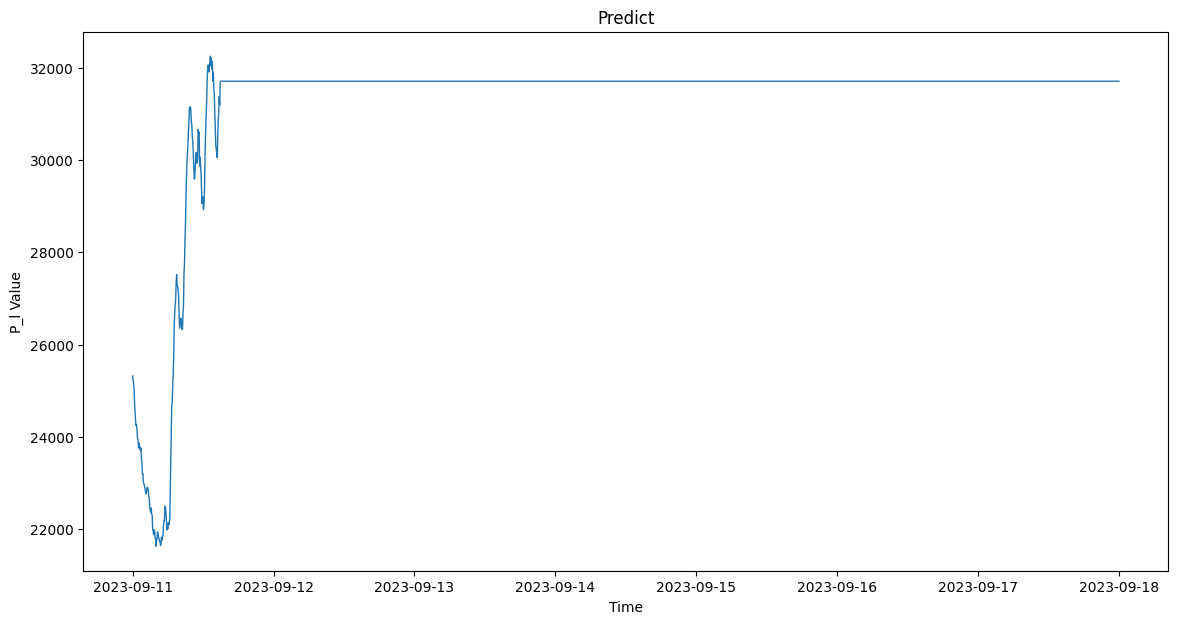

In [33]:

import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import load_model

dates_to_predict = pd.date_range(start='2023-09-11', end='2023-09-18', freq='5T')
dates_to_predict = pd.to_datetime(dates_to_predict)

google_drive_path = '/content/gdrive/MyDrive/'
model_path = google_drive_path + f'model_e_{epochs}_bs_{batch_size}.h5'

model =  load_model(model_path)

predicted_df = predict_consumption(dates_to_predict, model, df_Pl, scaler, look_back)

print(predicted_df)

plt.figure(figsize=(14, 7))
plt.plot(predicted_df['time'], predicted_df['P_l'], linewidth=1)
plt.title(label="Predict")
plt.ylabel("P_l Value")
plt.xlabel("Time")
plt.show()


In [34]:
predicted_df.to_csv(r'/Users/nikitasavvin/predicted_df.csv')

OSError: ignored